In [104]:
# %%capture 
# %load_ext autoreload
# %autoreload 2
# %reset -f

In [105]:
import os
import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re


### Initialize the Variables

In [106]:
chan_names = ['POz','PO3','PO4','PO7','PO8','Oz','O1','O2']
chan_nums = list(range(1,9)) # make list from 1 to 8

# left hemisphere -> odd numbers (1,3,5,7) 
left_hemisphere = [chan for chan in chan_names if chan[-1].isdigit() and int(chan[-1]) % 2 != 0]
# right hemisphere -> even numbers (2,4,6,8)
right_hemisphere = [chan for chan in chan_names if chan[-1].isdigit() and int(chan[-1]) % 2 == 0]
# midline -> z
midline_hemisphere = [chan for chan in chan_names if chan[-1] == 'z']

fs, lf, hf = 2000, 2, 45 #Hz
folder_path = 'data/Alken-29March/'

In [107]:
dat_paths = [folder_path+f for f in os.listdir(folder_path) if f.endswith('.dat')]
raw_list = []
for f in dat_paths:
    raw = mne.io.read_raw_curry(f, preload=True, verbose=False)
    # Set the filename attribute to the name of the file
    filename = os.path.basename(os.path.splitext(raw.filenames[0])[0])
    filename = filename.replace('_', '.')

    match_both = re.search(r'-B(?P<freq>\d+\.\d+|\d+)$', filename)
    match_rl = re.search(r'-R(?P<right_freq>\d+\.?\d*)L(?P<left_freq>\d+\.?\d*)$', filename)

    if match_both:
        freq = float(match_both.group('freq'))
        left_freq = [float(freq)]
        right_freq = [float(freq)]
        name = filename[:-len(match_both.group(0))]
    elif match_rl:
        name = filename[:-len(match_rl.group(0))]
        left_freq = [float(match_rl.group('right_freq'))]
        right_freq = [float(match_rl.group('left_freq'))]
    else:
        name = filename
        right_freq = []
        left_freq = []

    raw.filename = name
    raw.right_freq = right_freq
    raw.left_freq = left_freq 
    raw_list.append(raw)
# keep only picks in chan_names
raw_list = [raw.pick_channels(chan_names) for raw in raw_list]

### Filter

In [108]:
# filtered in the 4-45 Hz frequency band
# with a fourth order zero-phase digital Butterworth filter
for raw in raw_list:
    raw.filter(lf, hf, method='fir', fir_design='firwin', phase='zero-double', verbose=False) 

In [109]:
def plot(raw, chan_names, lf, hf):
    fig = raw.plot(show_scalebars=False, show_scrollbars=False, show_options=False, show=False, duration=60)
    fig.axes[0].set_title(raw.filename)
    fig.set_size_inches(15, 3)
    plt.tight_layout()
    plt.show()

# for raw in raw_list:
#     window = 6 # seconds
#     lf = 4 # Hz
#     hf = 25 # Hz
#     plot(raw, chan_names, lf, hf)

In [110]:
def plot_psd(raw, window, chan_names, lf, hf):
    spectrum = raw.compute_psd(verbose=False,n_fft=fs*window, n_per_seg=fs*window, fmin=lf, fmax=hf, picks=chan_names)
    fig = spectrum.plot()
    fig.axes[0].set_title(raw.filename)
    # set ylim 40
    fig.axes[0].set_ylim(0, 50)
    plt.show()

# for raw in raw_list:
#     window = 10 # seconds
#     lf = 4 # Hz
#     hf = 25 # Hz
#     plot_psd(raw, window, chan_names, lf, hf)

In [111]:
# https://mne.tools/dev/auto_tutorials/time-freq/50_ssvep.html

def snr_spectrum(psd, noise_n_neighbor_freqs=1, noise_skip_neighbor_freqs=1):
    """Compute SNR spectrum from PSD spectrum using convolution.

    Parameters
    ----------
    psd : ndarray, shape ([n_trials, n_channels,] n_frequency_bins)
        Data object containing PSD values. Works with arrays as produced by
        MNE's PSD functions or channel/trial subsets.
    noise_n_neighbor_freqs : int
        Number of neighboring frequencies used to compute noise level.
        increment by one to add one frequency bin ON BOTH SIDES
    noise_skip_neighbor_freqs : int
        set this >=1 if you want to exclude the immediately neighboring
        frequency bins in noise level calculation

    Returns
    -------
    snr : ndarray, shape ([n_trials, n_channels,] n_frequency_bins)
        Array containing SNR for all epochs, channels, frequency bins.
        NaN for frequencies on the edges, that do not have enough neighbors on
        one side to calculate SNR.
    """
    # Construct a kernel that calculates the mean of the neighboring
    # frequencies
    averaging_kernel = np.concatenate((
        np.ones(noise_n_neighbor_freqs),
        np.zeros(2 * noise_skip_neighbor_freqs + 1),
        np.ones(noise_n_neighbor_freqs)))
    averaging_kernel /= averaging_kernel.sum()

    # Calculate the mean of the neighboring frequencies by convolving with the
    # averaging kernel.
    mean_noise = np.apply_along_axis(
        lambda psd_: np.convolve(psd_, averaging_kernel, mode='valid'),
        axis=-1, arr=psd
    )

    # The mean is not defined on the edges so we will pad it with nas. The
    # padding needs to be done for the last dimension only so we set it to
    # (0, 0) for the other ones.
    edge_width = noise_n_neighbor_freqs + noise_skip_neighbor_freqs
    pad_width = [(0, 0)] * (mean_noise.ndim - 1) + [(edge_width, edge_width)]
    mean_noise = np.pad(
        mean_noise, pad_width=pad_width, constant_values=np.nan
    )

    return psd / mean_noise

In [120]:
def plot_snr(raw, fmin, fmax, sfreq, left_hemisphere, right_hemisphere, midline_hemisphere, epoch_length=10, nfft=1, nperseg=1):
    nfft = int(sfreq * nfft)
    nperseg = int(sfreq * nperseg)
    overlap = 0.0  
    noverlap = 0

    # raw.info['line_freq'] = freq
    raw_midline = raw.copy().pick_channels(midline_hemisphere)
    raw_left = raw.copy().pick_channels(left_hemisphere)
    raw_right = raw.copy().pick_channels(right_hemisphere)

    # Set montage
    montage = mne.channels.make_standard_montage('easycap-M1')
    raw_left.set_montage(montage, verbose=False)

    # Set common average reference
    raw_left.set_eeg_reference('average', projection=False, verbose=False)

    epochs = mne.make_fixed_length_epochs(raw_left, duration=epoch_length, verbose=False)

    spectrum = epochs.compute_psd( 'welch', n_fft=nfft, n_overlap=noverlap, n_per_seg=nperseg, fmin=fmin, fmax=fmax, window='boxcar', verbose=False)
    psds, freqs = spectrum.get_data(return_freqs=True)

    snrs = snr_spectrum(psds, noise_n_neighbor_freqs=3, noise_skip_neighbor_freqs=1)

    fig, axes = plt.subplots(2, 3, sharex='all', sharey='none', figsize=(8, 5))
        
    psds_plot = 10 * np.log10(psds)
    psds_mean = psds_plot.mean(axis=(0, 1))
    psds_std = psds_plot.std(axis=(0, 1))
    axes[0][0].plot(freqs, psds_mean, color='b')
    axes[0][0].fill_between(freqs, psds_mean - psds_std, psds_mean + psds_std, color='b', alpha=.2)
    axes[0][0].set(title="Left Hemisphere: PSD spectrum", ylabel='Power Spectral Density [dB]')

    # SNR spectrum
    snr_mean = snrs.mean(axis=(0, 1))
    snr_std = snrs.std(axis=(0, 1))

    axes[1][0].plot(freqs, snr_mean, color='r')
    axes[1][0].fill_between(freqs, snr_mean - snr_std, snr_mean + snr_std, color='r', alpha=.2)
    axes[1][0].set(title="Left Hemisphere: SNR spectrum", xlabel='Frequency [Hz]', ylabel='SNR', ylim=[-2, 10], xlim=[fmin, fmax])
    

    # midline hemisphere
    raw_midline.set_montage(montage, verbose=False)

    # Set common average reference
    raw_midline.set_eeg_reference('average', projection=False, verbose=False)

    # Apply bandpass filter
    epochs = mne.make_fixed_length_epochs(raw_midline, duration=epoch_length, overlap=overlap, verbose=False)

    spectrum = epochs.compute_psd( 'welch', n_fft=nfft, n_overlap=noverlap, n_per_seg=nperseg, 
                                  fmin=fmin, fmax=fmax, window='boxcar', verbose=False)
    psds, freqs = spectrum.get_data(return_freqs=True)

    snrs = snr_spectrum(psds, noise_n_neighbor_freqs=3, noise_skip_neighbor_freqs=1)

    psds_plot = 10 * np.log10(psds)
    psds_mean = psds_plot.mean(axis=(0, 1))
    psds_std = psds_plot.std(axis=(0, 1))
    axes[0][1].plot(freqs, psds_mean, color='b')
    axes[0][1].fill_between(freqs,
        psds_mean - psds_std, psds_mean + psds_std,
        color='b', alpha=.2)
    axes[0][1].set(title="Midline Hemisphere: PSD spectrum", ylabel='Power Spectral Density [dB]')

    # SNR spectrum
    snr_mean = snrs.mean(axis=(0, 1))
    snr_std = snrs.std(axis=(0, 1))

    axes[1][1].plot(freqs, snr_mean, color='r')
    axes[1][1].fill_between(freqs, snr_mean - snr_std, snr_mean + snr_std, color='r', alpha=.2)
    axes[1][1].set(title="Midline Hemisphere: SNR spectrum", xlabel='Frequency [Hz]', ylabel='SNR', ylim=[-2, 10], xlim=[fmin, fmax])
   

    # right hemisphere
    raw_right.set_montage(montage, verbose=False)

    # Set common average reference
    raw_right.set_eeg_reference('average', projection=False, verbose=False)

    # Apply bandpass filter
    epochs = mne.make_fixed_length_epochs(raw_right, duration=epoch_length, overlap=overlap, verbose=False)

    spectrum = epochs.compute_psd( 'welch', n_fft=nfft, n_overlap=noverlap, n_per_seg=nperseg, 
                                  fmin=fmin, fmax=fmax, window='boxcar', verbose=False)
    psds, freqs = spectrum.get_data(return_freqs=True)

    snrs = snr_spectrum(psds, noise_n_neighbor_freqs=3, noise_skip_neighbor_freqs=1)

    psds_plot = 10 * np.log10(psds)
    psds_mean = psds_plot.mean(axis=(0, 1))
    psds_std = psds_plot.std(axis=(0, 1))
    axes[0][2].plot(freqs, psds_mean, color='b')
    axes[0][2].fill_between(freqs, psds_mean - psds_std, psds_mean + psds_std, color='b', alpha=.2)
    axes[0][2].set(title="Right Hemisphere: PSD spectrum", ylabel='Power Spectral Density [dB]')

    # SNR spectrum
    snr_mean = snrs.mean(axis=(0, 1))
    snr_std = snrs.std(axis=(0, 1))

    axes[1][2].plot(freqs, snr_mean, color='r')
    axes[1][2].fill_between(freqs, snr_mean - snr_std, snr_mean + snr_std, color='r', alpha=.2)
    axes[1][2].set(title="Right Hemisphere: SNR spectrum", xlabel='Frequency [Hz]', ylabel='SNR', ylim=[-2, 10], xlim=[fmin, fmax])

    # increase time increment for x-axis
    xticks = np.arange(fmin, fmax, 2)
    axes[1][0].set_xticks(xticks)
    # Add vertical lines for raw.left_freq
    # add the natural harmonics to the freq:

    left_freq = raw.left_freq
    right_freq = raw.right_freq
    for freq in left_freq:
        left_freq = np.append(left_freq, [freq*2, freq*3, freq*4])
    for freq in right_freq:
        right_freq = np.append(right_freq, [freq*2, freq*3, freq*4])

    for freq in left_freq:
        axes[0][0].axvline(freq, color='lightgray', linestyle='--', linewidth=1)
        axes[1][0].axvline(freq, color='lightgray', linestyle='--', linewidth=1)
        axes[0][1].axvline(freq, color='lightgray', linestyle='--', linewidth=1)
        axes[1][1].axvline(freq, color='lightgray', linestyle='--', linewidth=1)
   
    # Add vertical lines for raw.right_freq
    for freq in right_freq:
        axes[0][1].axvline(freq, color='lightgray', linestyle='--', linewidth=1)
        axes[1][1].axvline(freq, color='lightgray', linestyle='--', linewidth=1)
        axes[0][2].axvline(freq, color='lightgray', linestyle='--', linewidth=1)
        axes[1][2].axvline(freq, color='lightgray', linestyle='--', linewidth=1)

    fig.suptitle(raw.filename)
    fig.set_size_inches(15, 5)
    fig.tight_layout()
    plt.show()


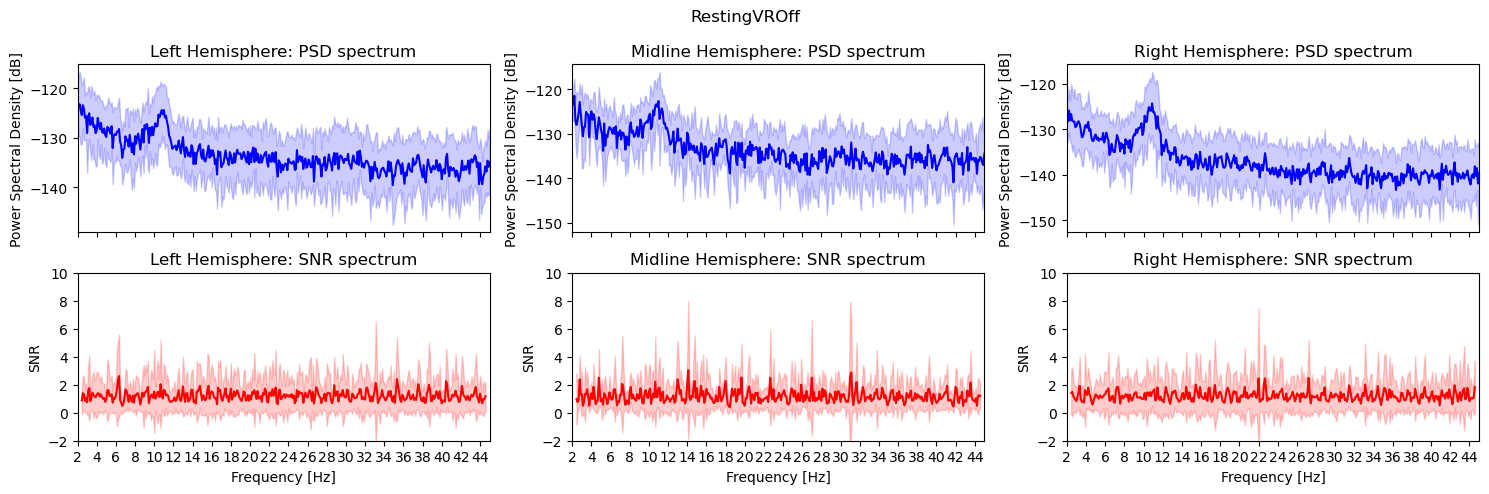

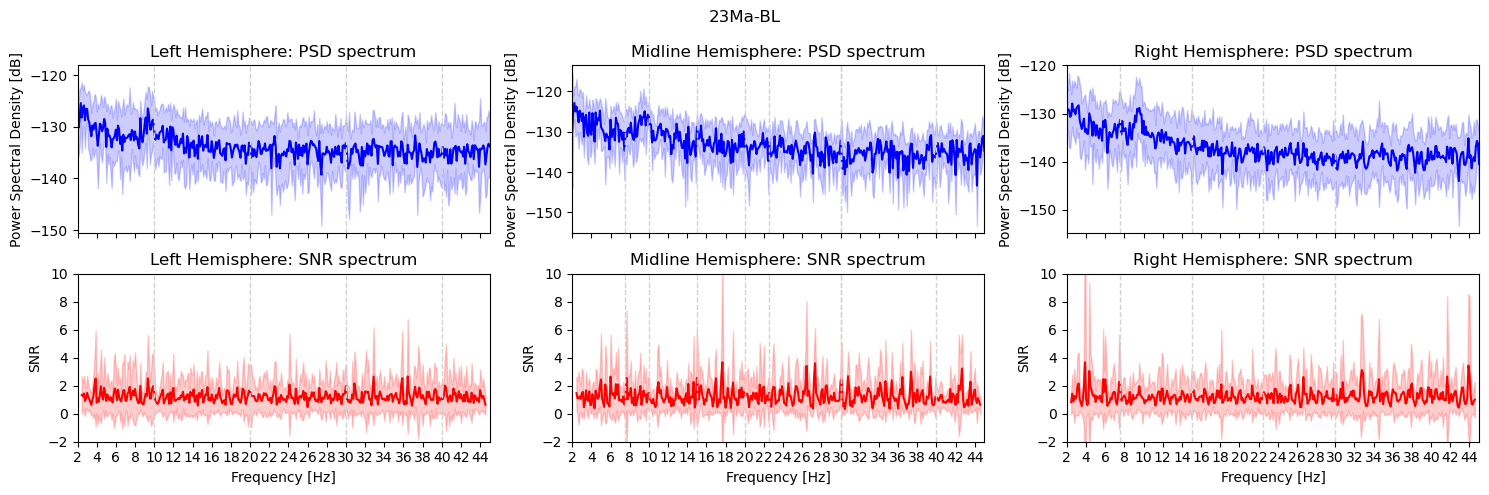

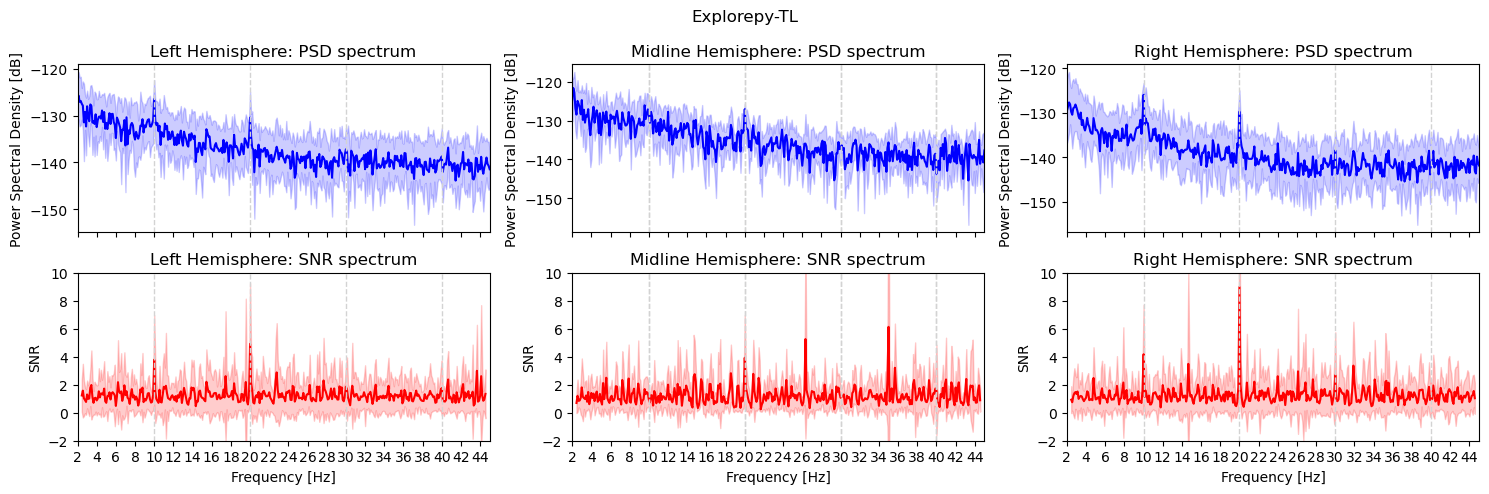

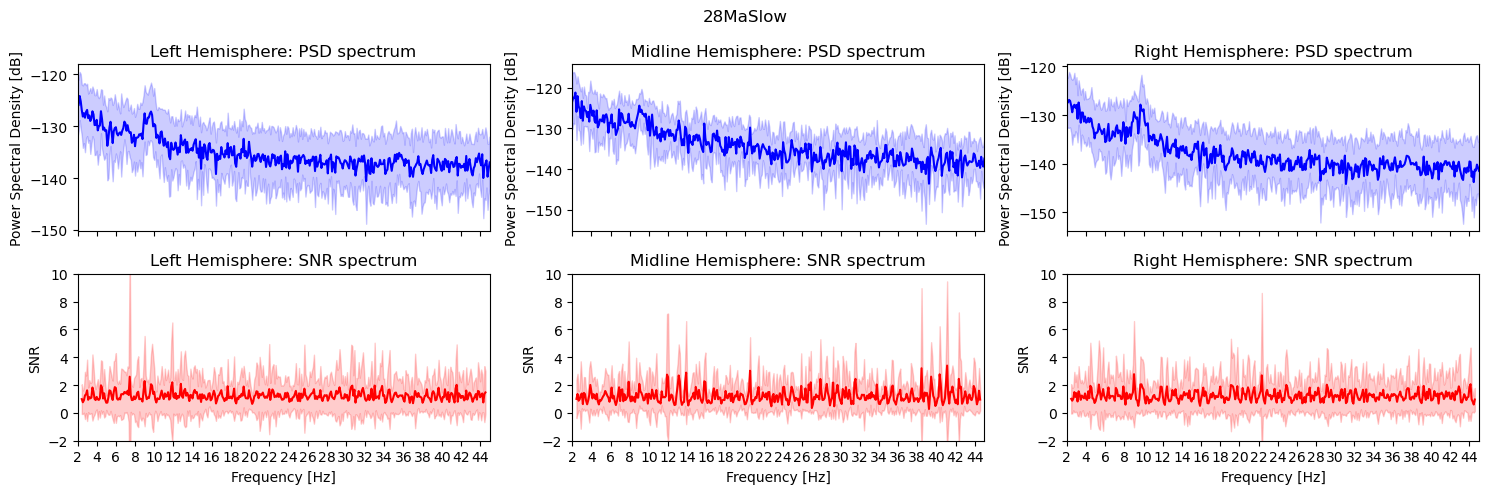

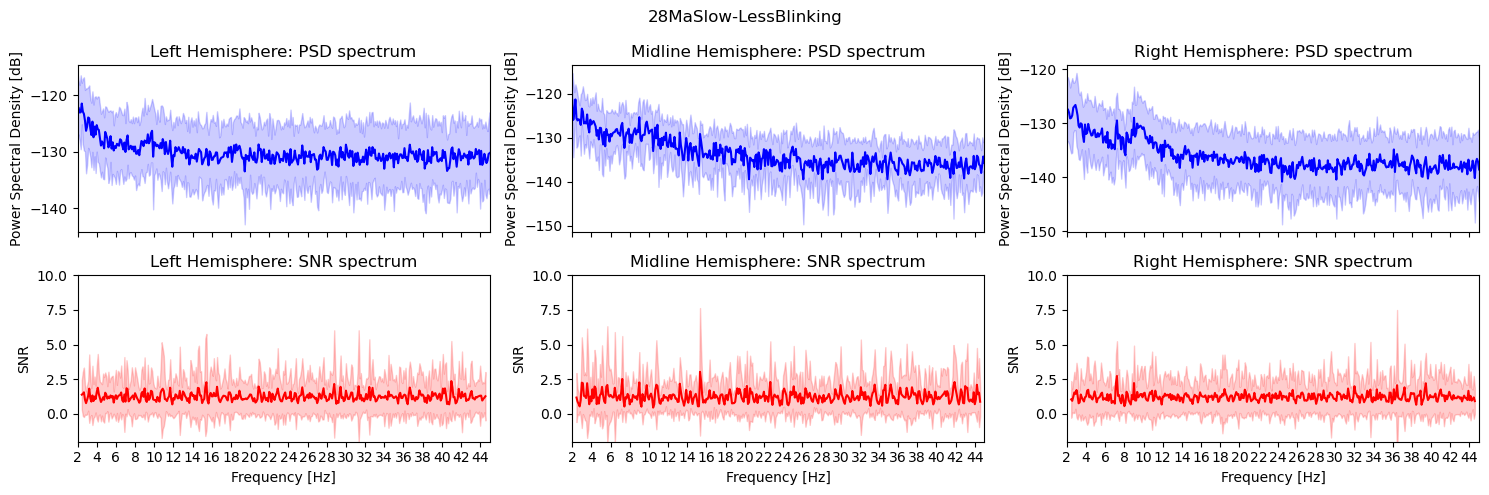

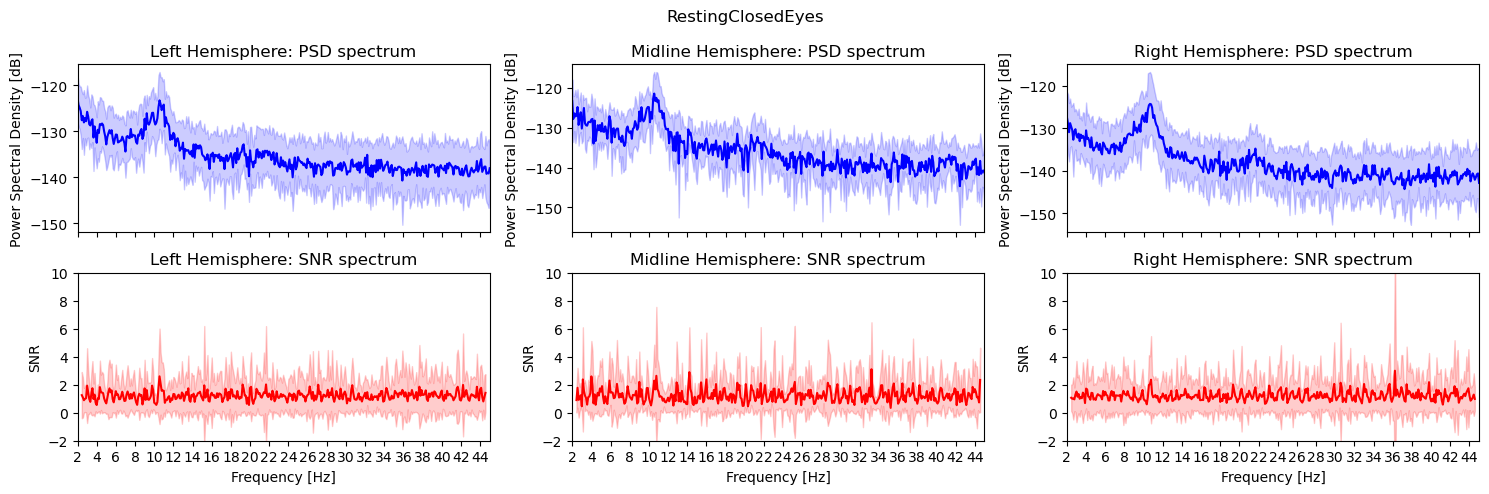

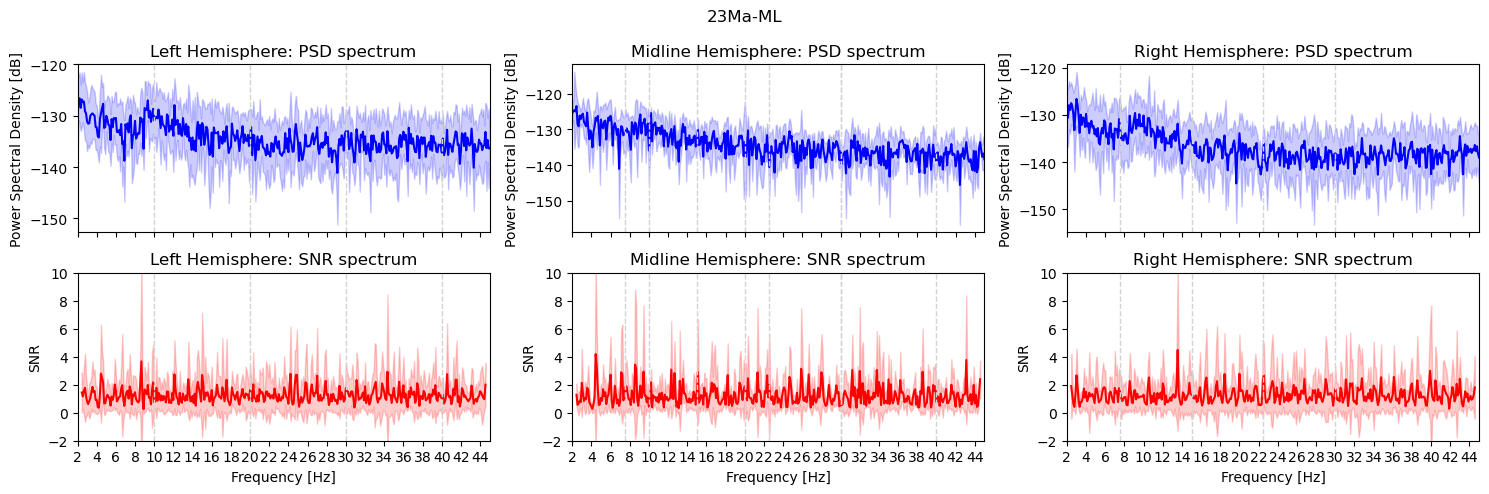

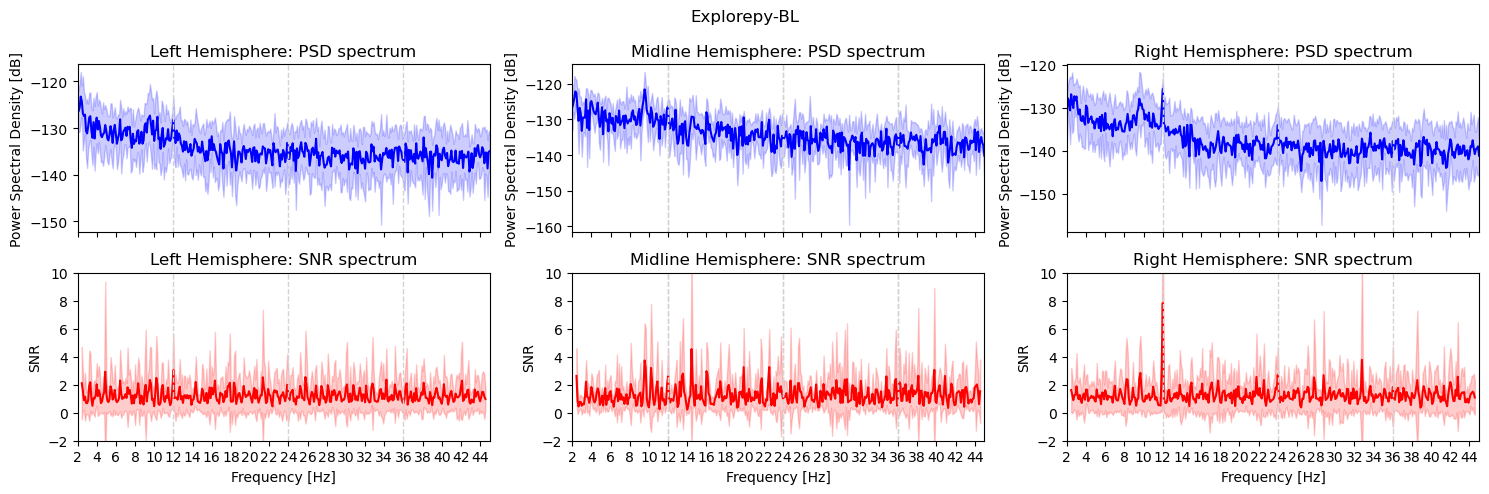

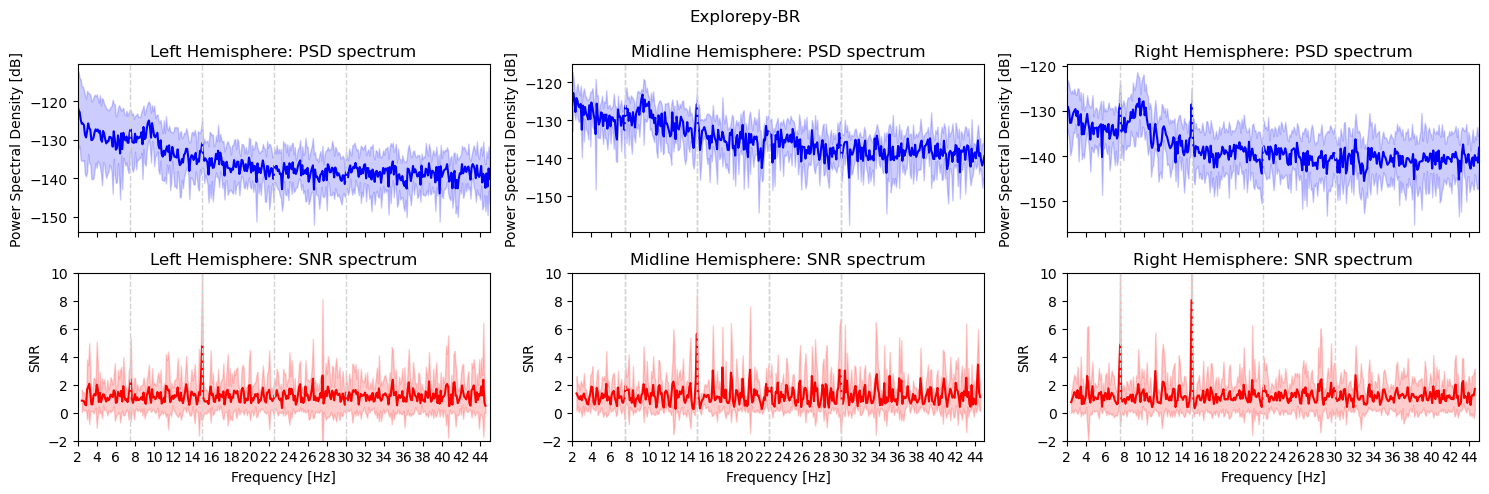

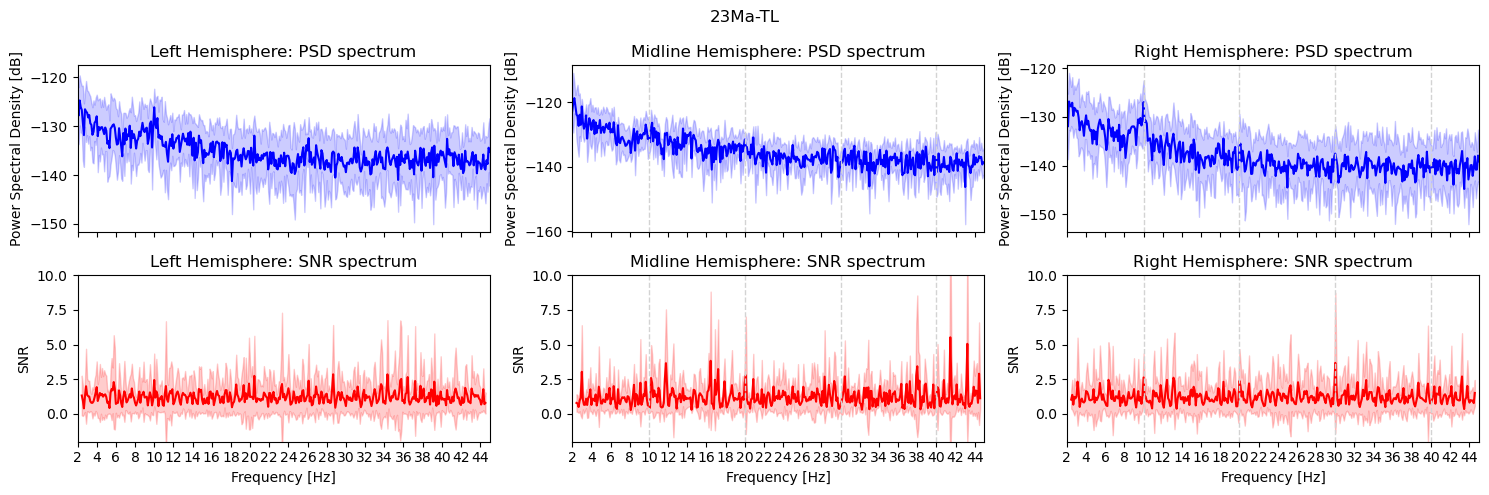

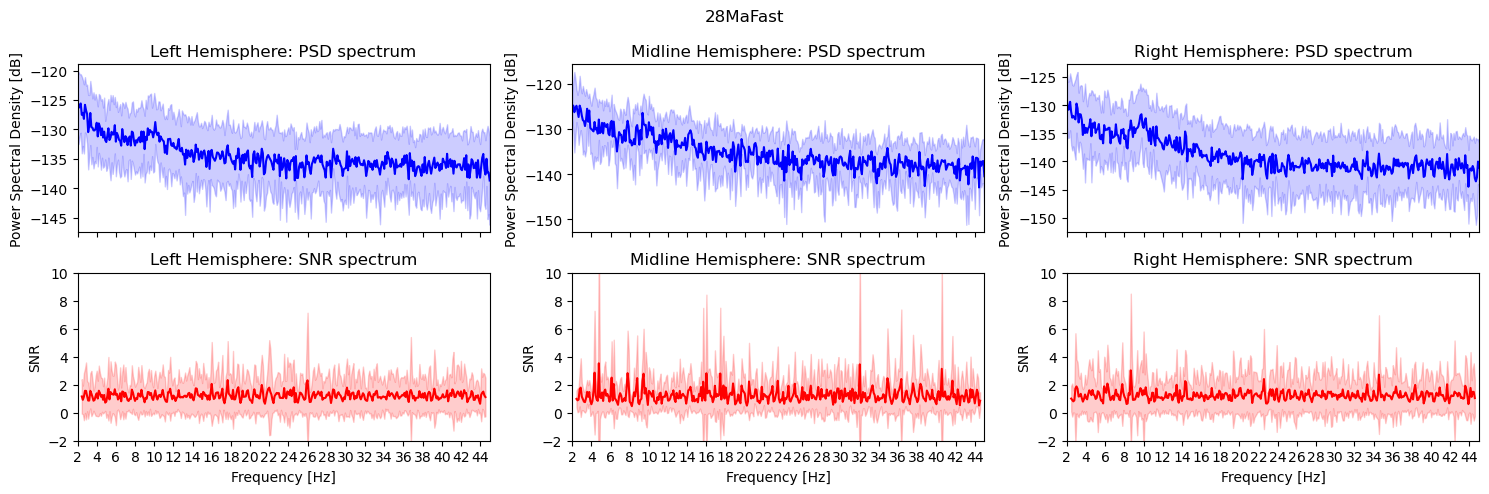

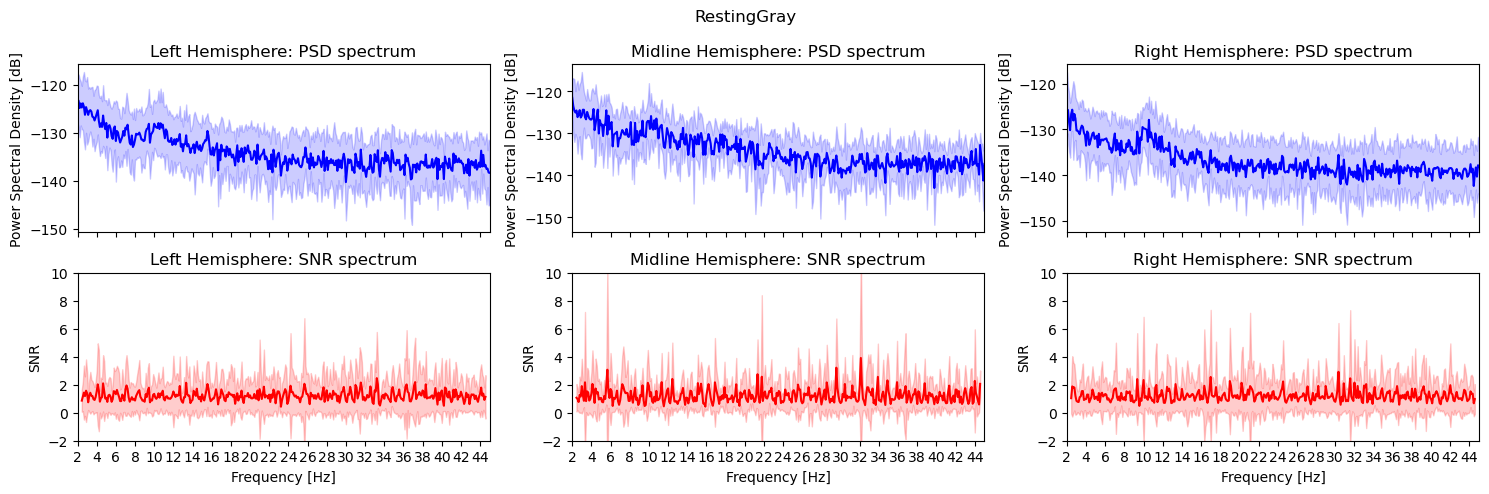

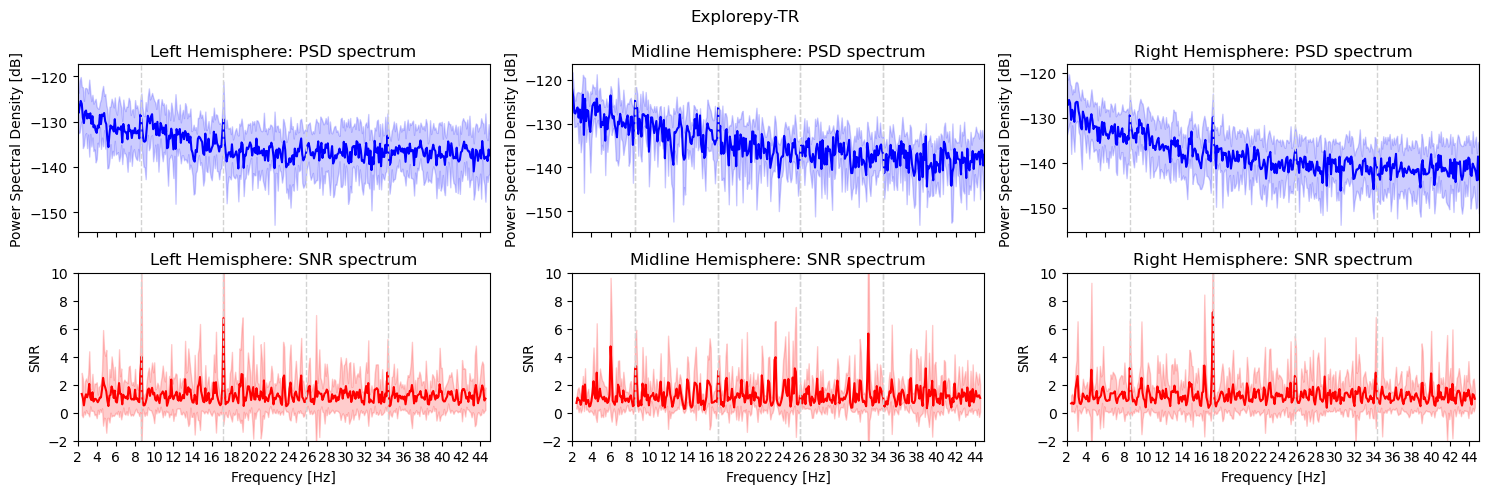

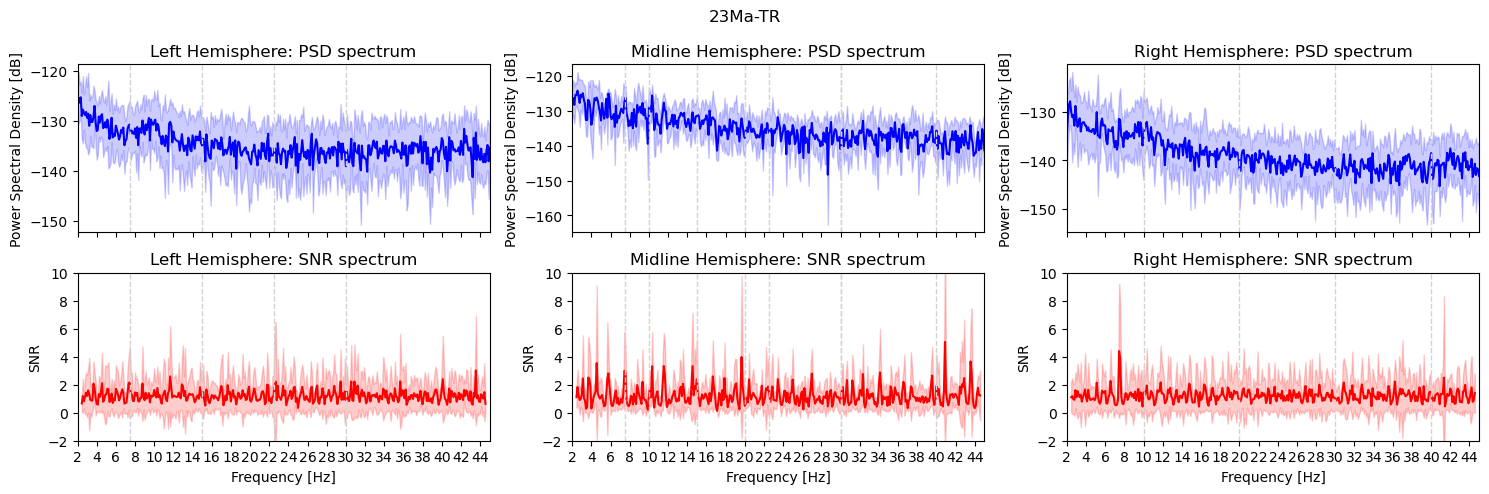

In [121]:
fmin = lf
fmax = hf

for raw in raw_list:
    # if '23Ma' in raw.filename:
        plot_snr(raw, fmin, fmax, fs,left_hemisphere, right_hemisphere, midline_hemisphere,epoch_length=6, nfft=9, nperseg=9)

I don't think that the PSD or SNR is going to do much better than this. Playing around with the parameters is not leading to anything. 